# taxi-trip-duration-prediction

Use the "Run" button to execute the code.

In [2]:
!pip install jovian geopy --upgrade --quiet

In [3]:
import jovian

![image.png](attachment:image.png)

In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

Longtime Kagglers will recognize that this competition objective is similar to the ECML/PKDD trip time challenge we hosted in 2015. But, this challenge comes with a twist. Instead of awarding prizes to the top finishers on the leaderboard, this playground competition was created to reward collaboration and collective learning.

We are encouraging you (with cash prizes!) to publish additional training data that other participants can use for their predictions. We also have designated bi-weekly and final prizes to reward authors of kernels that are particularly insightful or valuable to the community.

# Problem Statement

The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

# Importing the libraries

Before importing let's install all the libraries that are going to be used in the notebook.

In [4]:
pip install numpy pandas matplotlib seaborn sklearn opendatasets xgboost --quiet

In [5]:
import os
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')
pd.set_option("display.max_columns", None)

# Downloading the data
We can download the dataset from Kaggle directly within the Jupyter notebook using the opendatasets library.

The dataset is available at https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data

In [6]:

od.download('https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data') # downloading the dataset by providing the url

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omkarhirugade
Your Kaggle Key: ··········


100%|██████████| 85.8M/85.8M [00:04<00:00, 19.4MB/s]



Extracting archive ./nyc-taxi-trip-duration/nyc-taxi-trip-duration.zip to ./nyc-taxi-trip-duration


In [7]:
os.listdir('nyc-taxi-trip-duration') # list of files in the nyc-taxi-trip-duration directory


['sample_submission.zip', 'test.zip', 'train.zip']

In [8]:
import zipfile
with zipfile.ZipFile('./nyc-taxi-trip-duration/train.zip', 'r') as zip_ref:
    zip_ref.extractall('nyc-taxi-trip-duration')


In [9]:
with zipfile.ZipFile('./nyc-taxi-trip-duration/test.zip', 'r') as zip_ref:
    zip_ref.extractall('nyc-taxi-trip-duration')


In [10]:
with zipfile.ZipFile('./nyc-taxi-trip-duration/sample_submission.zip', 'r') as zip_ref:
    zip_ref.extractall('nyc-taxi-trip-duration')


# Reading the dataset

In [11]:
train_df=pd.read_csv('./nyc-taxi-trip-duration/train.csv',nrows=100)
test_df=pd.read_csv('./nyc-taxi-trip-duration/test.csv',nrows=20)

In [12]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Feature Description:

id - a unique identifier for each trip

vendor_id - a code indicating the provider associated with the trip record

pickup_datetime - date and time when the meter was engaged

dropoff_datetime - date and time when the meter was disengaged

passenger_count - the number of passengers in the vehicle (driver entered value)

pickup_longitude - the longitude where the meter was engaged

pickup_latitude - the latitude where the meter was engaged

dropoff_longitude - the longitude where the meter was disengaged

dropoff_latitude - the latitude where the meter was disengaged

store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

trip_duration - duration of the trip in seconds

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  100 non-null    object 
 1   vendor_id           100 non-null    int64  
 2   pickup_datetime     100 non-null    object 
 3   dropoff_datetime    100 non-null    object 
 4   passenger_count     100 non-null    int64  
 5   pickup_longitude    100 non-null    float64
 6   pickup_latitude     100 non-null    float64
 7   dropoff_longitude   100 non-null    float64
 8   dropoff_latitude    100 non-null    float64
 9   store_and_fwd_flag  100 non-null    object 
 10  trip_duration       100 non-null    int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 8.7+ KB


Here we have to convert the pickup and dropoff to datetime 

In [14]:
train_df.describe() # descriptive statisitics of train data

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.480000,1.430000,-73.973521,40.748470,-73.969231,40.747412,984.980000
std,0.502117,1.027451,0.040302,0.028275,0.043674,0.032011,685.815079
min,1.000000,1.000000,-74.016327,40.643559,-74.012268,40.641472,57.000000
25%,1.000000,1.000000,-73.993574,40.737203,-73.995106,40.728586,466.250000
50%,1.000000,1.000000,-73.981762,40.753716,-73.980652,40.748802,777.000000
75%,2.000000,1.000000,-73.968266,40.767100,-73.961336,40.765676,1276.250000
max,2.000000,6.000000,-73.782478,40.806606,-73.788750,40.864029,3528.000000


## Converting the Objects into datetime

In [15]:
train_df["pickup_datetime"]= pd.to_datetime(train_df["pickup_datetime"])
train_df["dropoff_datetime"]= pd.to_datetime(train_df["dropoff_datetime"])

In [16]:
train_df['pickup_day']= train_df["pickup_datetime"].dt.day_name()
train_df['dropoff_day']= train_df["dropoff_datetime"].dt.day_name()

In [17]:
train_df['pickup_month']= train_df["pickup_datetime"].dt.month_name()
train_df['dropoff_month']= train_df["dropoff_datetime"].dt.month_name()

In [18]:
train_df['pickup_day_no']=train_df['pickup_datetime'].dt.weekday
train_df['dropoff_day_no']=train_df['dropoff_datetime'].dt.weekday

In [19]:
train_df['pickup_hour']=train_df['pickup_datetime'].dt.hour
train_df['dropoff_hour']=train_df['dropoff_datetime'].dt.hour

### We have created the following features:

pickup_day and dropoff_day which will contain the name of the day on which the ride was taken.

pickup_day_no and dropoff_day_no which will contain the day number instead of characters with Monday=0 and Sunday=6.

pickup_hour and dropoff_hour with an hour of the day in the 24-hour format.

pickup_month and dropoff_month with month number with January=1 and December=12.

Next, I have defined a function that lets us determine what time of the day the ride was taken. I have created 4 time zones ‘Morning’ (from 6:00 am to 11:59 pm), ‘Afternoon’ (from 12 noon to 3:59 pm), ‘Evening’ (from 4:00 pm to 9:59 pm), and ‘Late Night’ (from 10:00 pm to 5:59 am)

In [20]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [21]:
train_df['pickup_timeofday']=train_df['pickup_hour'].apply(time_of_day)
train_df['dropoff_timeofday']=train_df['dropoff_hour'].apply(time_of_day)

We also saw during dataset exploration that we have coordinates in the form of longitude and latitude for pickup and dropoff. But, we can’t really gather any insights or draw conclusions from that.
So, the most obvious feature that we can extract from this is distance. Let us do that.

Importing the library which lets us calculate distance from geographical coordinates.

Defining a function to take coordinates as inputs and return us distance.



In [22]:
def distance(lat1, lon1, lat2, lon2):
  p = 0.017453292519943295 # Pi/180
  a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p))/2
  return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

Finally, applying the function to our dataset and creating the feature ‘distance’.

In [23]:
train_df["distance_miles"] = distance(train_df["pickup_latitude"], train_df["pickup_longitude"], 
                                      train_df["dropoff_latitude"], train_df["dropoff_longitude"])

In [24]:
train_df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_day_no,dropoff_day_no,pickup_hour,dropoff_hour,pickup_timeofday,dropoff_timeofday,distance_miles
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,March,March,0,0,17,17,Evening,Evening,0.931138
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,June,June,6,6,0,0,Late night,Late night,1.121890
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,January,January,1,1,11,12,Morning,Afternoon,3.967516
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,April,April,2,2,19,19,Evening,Evening,0.923046
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,March,March,5,5,13,13,Afternoon,Afternoon,0.738555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,id3025098,2,2016-01-20 19:21:31,2016-01-20 19:31:27,1,-73.976982,40.750301,-73.999123,40.739510,N,596,Wednesday,Wednesday,January,January,2,2,19,19,Evening,Evening,1.378121
96,id3333094,2,2016-06-02 23:34:00,2016-06-02 23:41:15,1,-73.973465,40.755230,-73.977364,40.742821,N,435,Thursday,Thursday,June,June,3,3,23,23,Late night,Late night,0.881344
97,id2228940,1,2016-02-04 13:22:02,2016-02-04 13:40:30,1,-73.981865,40.758774,-73.970222,40.784142,N,1108,Thursday,Thursday,February,February,3,3,13,13,Afternoon,Afternoon,1.855594
98,id2102594,1,2016-03-30 16:14:29,2016-03-30 17:01:33,1,-73.789841,40.643559,-73.970665,40.687279,N,2824,Wednesday,Wednesday,March,March,2,2,16,17,Evening,Evening,9.946651


# Locations of pickup and dropoff lats and longs

We use geopy to get the locations of pickup and dropoff points

In [25]:
from geopy.geocoders import Nominatim
from geopy.point import Point

In [26]:
geolocator = Nominatim(user_agent="geoapiExercises")

The function below gives the name of the road of pickup and dropoff location.

In [27]:
def city_state_country(lat,long):
    location = geolocator.reverse(Point(lat, long))
    address = location.raw['address']
    if 'road' in address:
        x=address['road']
    else:
        x='NA'
    return x

In [28]:
train_df["pickup_location"] = np.vectorize(city_state_country)(train_df["pickup_latitude"], train_df["pickup_longitude"])
train_df["dropoff_location"] = np.vectorize(city_state_country)(train_df["dropoff_latitude"], train_df["dropoff_longitude"])
                            

In [29]:
pd.set_option("display.max_colwidth", -1)

In [30]:
train_df["pickup_location"]

0     Columbus Circle   
1     2nd Avenue        
2     West 56th Street  
3     Greenwich Street  
4     Broadway          
        ...             
95    Lexington Avenue  
96    Madison Avenue    
97    Rockefeller Plaza 
98    NA                
99    Pennsylvania Plaza
Name: pickup_location, Length: 100, dtype: object

# EDA

## Target

Let us start by analyzing the target variable.

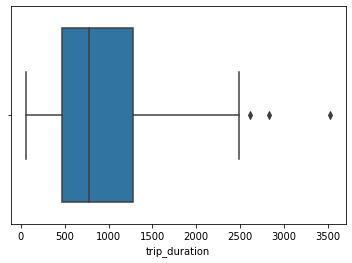

In [31]:
sns.boxplot(train_df['trip_duration'])

We can clearly see an outlier.

In [32]:
train_df['trip_duration'].sort_values(ascending=False)

55    3528
98    2824
57    2607
24    2485
93    2341
      ... 
83    218 
68    215 
15    211 
64    174 
72    57  
Name: trip_duration, Length: 100, dtype: int64

We can see that there is an entry which is significantly different from others.


## Vendor id

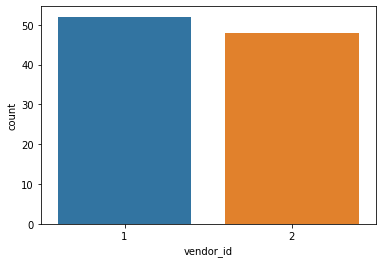

In [33]:
sns.countplot(x='vendor_id',data=train_df)

We see that there is not much difference between the trips taken by both vendors.

## Passenger Count

In [34]:
train_df.passenger_count.value_counts()

1    79
2    10
3    5 
4    3 
6    2 
5    1 
Name: passenger_count, dtype: int64

There are some trips with even 0 passenger count.
There is only 1 trip each for 7 and 9 passengers.

Text(0.5, 1.0, 'Distribution of Passenger count')

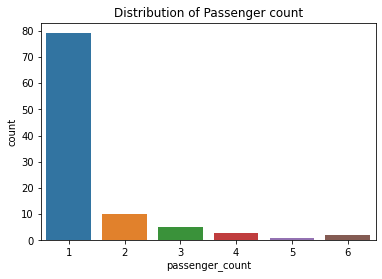

In [35]:
axis=sns.countplot(x=train_df['passenger_count'])
plt.title('Distribution of Passenger count')

Most of the passengers are single passengers

Let us remove the rows which have 0 or 7 or 9 passenger count.

## Store and Forward Flag

In [36]:
train_df['store_and_fwd_flag'].value_counts(normalize=True)

N    1.0
Name: store_and_fwd_flag, dtype: float64

We see there are less than 1% of trips that were stored before forwarding.

## Trips per Day

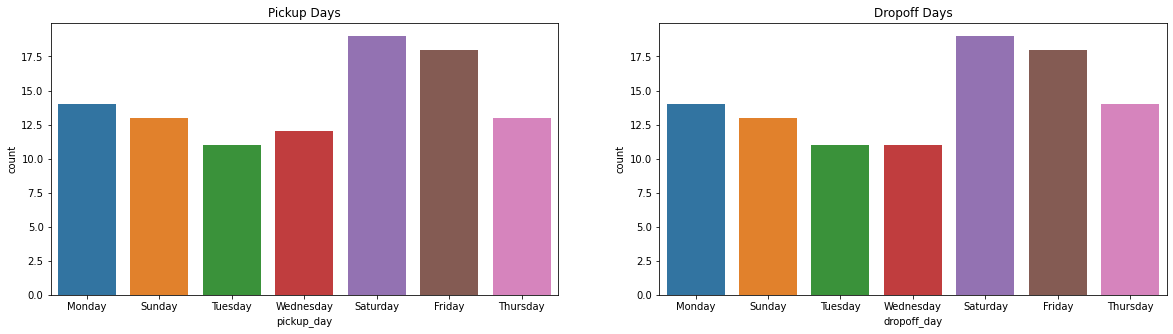

In [37]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day",data=train_df,ax=ax1)
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=train_df,ax=ax2)

We see Fridays are the busiest days followed by Saturdays. That is probably because it’s weekend.

## Trips per Hour

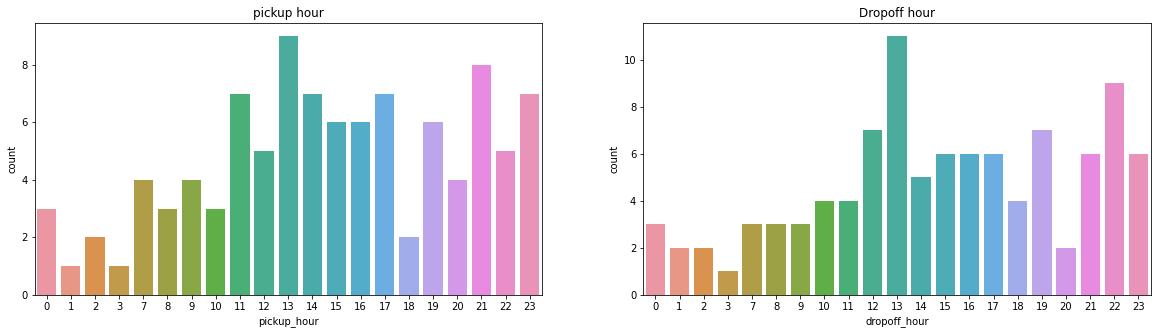

In [38]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('pickup hour')
ax=sns.countplot(x="pickup_hour",data=train_df,ax=ax1)
ax2.set_title('Dropoff hour')
ax=sns.countplot(x="dropoff_hour",data=train_df,ax=ax2)

We see the busiest hours are 6:00 pm to 7:00 pm and that makes sense as this is the time when people return from their offices.

## Trips per Time of Day

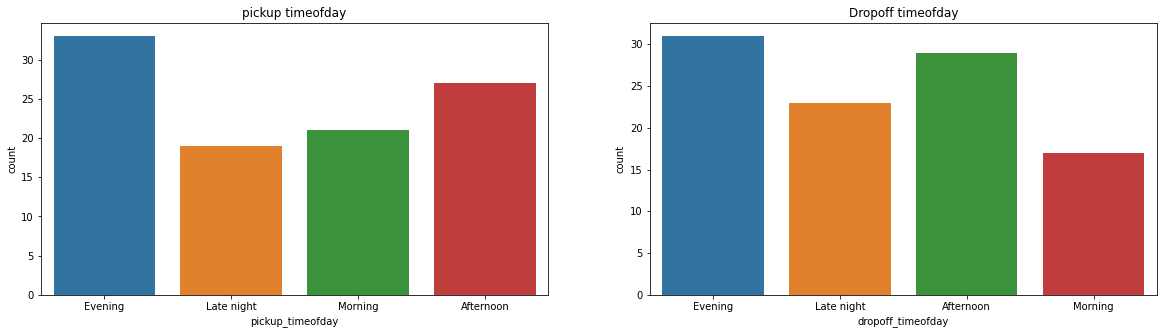

In [39]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('pickup timeofday')
ax=sns.countplot(x="pickup_timeofday",data=train_df,ax=ax1)
ax2.set_title('Dropoff timeofday')
ax=sns.countplot(x="dropoff_timeofday",data=train_df,ax=ax2)

As we saw above, evenings are the busiest.

## Trips per month

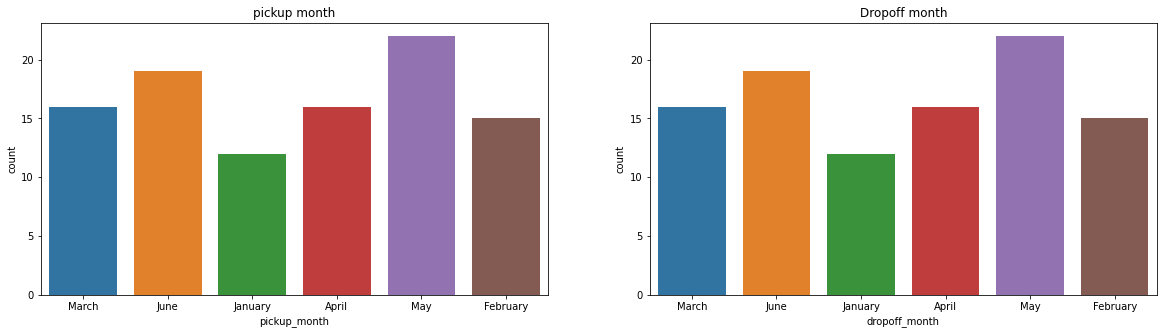

In [40]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('pickup month')
ax=sns.countplot(x="pickup_month",data=train_df,ax=ax1)
ax2.set_title('Dropoff month')
ax=sns.countplot(x="dropoff_month",data=train_df,ax=ax2)

There is not much difference in the number of trips across months.

# The pickup and dropoff locations

Text(0.5, 1.0, 'pickup_location')

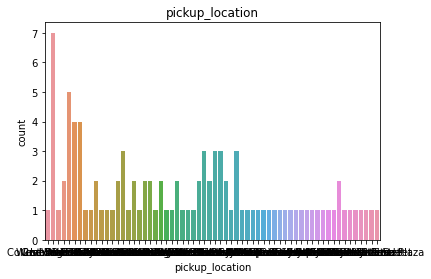

In [41]:
sns.countplot(x="pickup_location",data=train_df).set_title('pickup_location')

Text(0.5, 1.0, 'Dropoff_location')

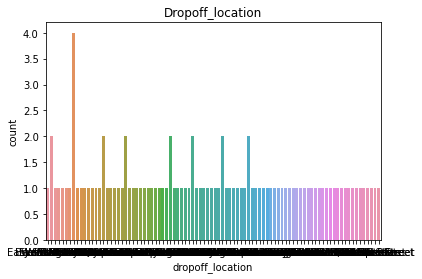

In [42]:
sns.countplot(x="dropoff_location",data=train_df).set_title('Dropoff_location')

## distance_miles

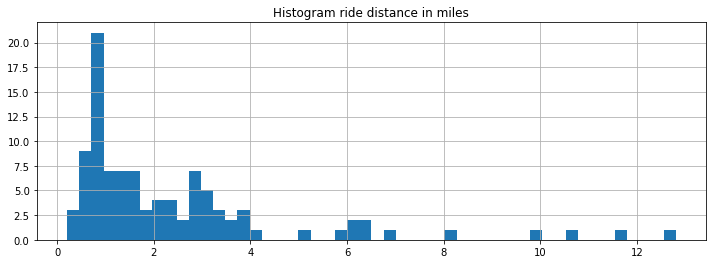

In [43]:
train_df["distance_miles"].hist(bins=50, figsize=(12,4))
plt.title("Histogram ride distance in miles");

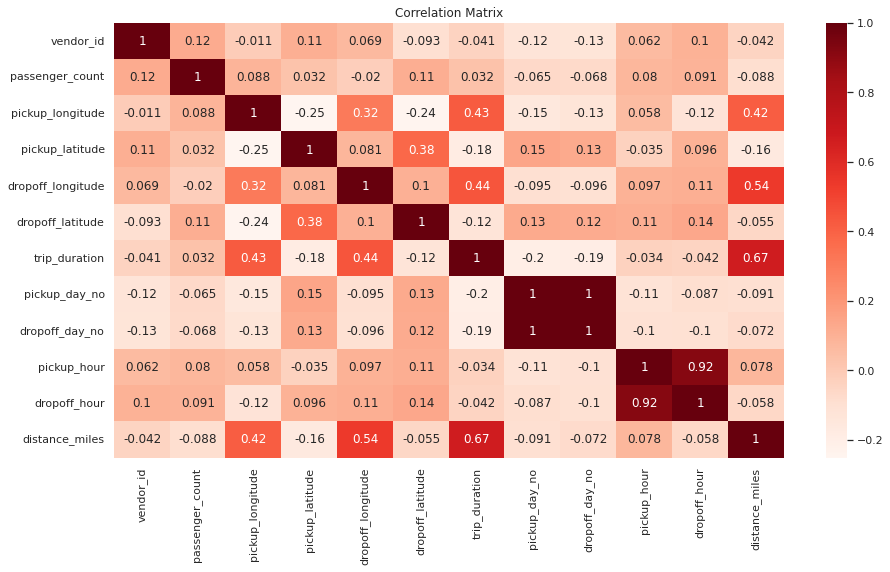

In [44]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(train_df.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

# Data Preprocessing

Here we are finalizing and sorting the features into two dataframes(categorical and numerical) for further encoding and processing

In [45]:
catogorical_df=train_df[['id','store_and_fwd_flag','pickup_day','pickup_month','pickup_location','dropoff_location']].copy()
numerical_df=train_df[['id','passenger_count','distance_miles','pickup_hour']].copy()

Defining the targets dataframe

In [46]:
targets=train_df[['trip_duration']].copy()

# One-hot encode categorical columns

Since ML models cannot process categorical data we need to tranform those data to numerical data.

In [47]:
from sklearn.preprocessing import  LabelEncoder

In [48]:
encoder = LabelEncoder()


In [49]:
catogorical_df['store_and_fwd_flag']=encoder.fit_transform(train_df['store_and_fwd_flag'])
catogorical_df['pickup_day']=encoder.fit_transform(train_df['pickup_day'])
catogorical_df['pickup_month']=encoder.fit_transform(train_df['pickup_month'])
catogorical_df['pickup_location']=encoder.fit_transform(train_df['pickup_location'])
catogorical_df['dropoff_location']=encoder.fit_transform(train_df['dropoff_location'])

Merging the numerical and categorical columns on the basis of 'id'

In [50]:
inputs_df=numerical_df.merge(catogorical_df,left_on='id', right_on='id')

Droppping the 'id' column as there is no use to the model

In [51]:
inputs_df=inputs_df.drop(['id'],axis='columns')

In [52]:
inputs_df

,passenger_count,distance_miles,pickup_hour,store_and_fwd_flag,pickup_day,pickup_month,pickup_location,dropoff_location
0,1,0.931138,17,0,1,4,17,34
1,1,1.121890,0,0,3,3,3,53
2,1,3.967516,11,0,5,2,58,15
3,1,0.923046,19,0,6,0,32,48
4,1,0.738555,13,0,2,4,12,86
...,...,...,...,...,...,...,...,...
95,1,1.378121,19,0,6,2,37,5
96,1,0.881344,23,0,4,3,38,28
97,1,1.855594,13,0,4,1,46,18
98,1,9.946651,16,0,6,4,41,9


# Create training and validation sets

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df, targets, test_size=0.20, random_state=42)

# Model 1 Decision Tree

The first model that I am going to train is a Decision Tree

In [55]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [56]:
tree = DecisionTreeRegressor(random_state=42)

In [57]:
tree.fit(train_inputs,train_targets)

DecisionTreeRegressor(random_state=42)

In [58]:
train_targets_pred=tree.predict(train_inputs)

In [59]:
train_loss = mean_squared_error(train_targets, train_targets_pred)


In [60]:
train_loss

0.0

In [61]:
tree.score(train_inputs,train_targets)

1.0

In [62]:
val_targets_pred=tree.predict(val_inputs)

In [63]:
val_loss= mean_squared_error(val_targets, val_targets_pred)

In [64]:
val_loss

181823.6

In [65]:
tree.score(val_inputs,val_targets)

0.5153699346439373

Text(0, 0.5, 'Predictions ')

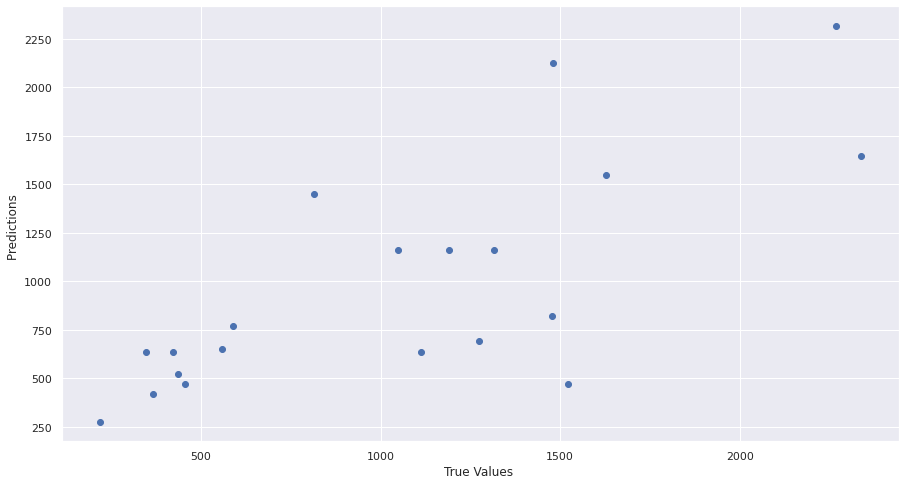

In [66]:
 plt.scatter(val_targets, val_targets_pred);
 plt.xlabel('True Values ')
 plt.ylabel('Predictions ')

In [67]:
tree_importances = tree.feature_importances_

In [68]:
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

In [69]:
tree_importance_df

,feature,importance
1,distance_miles,0.730924
5,pickup_month,0.090654
2,pickup_hour,0.090028
4,pickup_day,0.034112
6,pickup_location,0.026386
7,dropoff_location,0.022179
0,passenger_count,0.005717
3,store_and_fwd_flag,0.000000


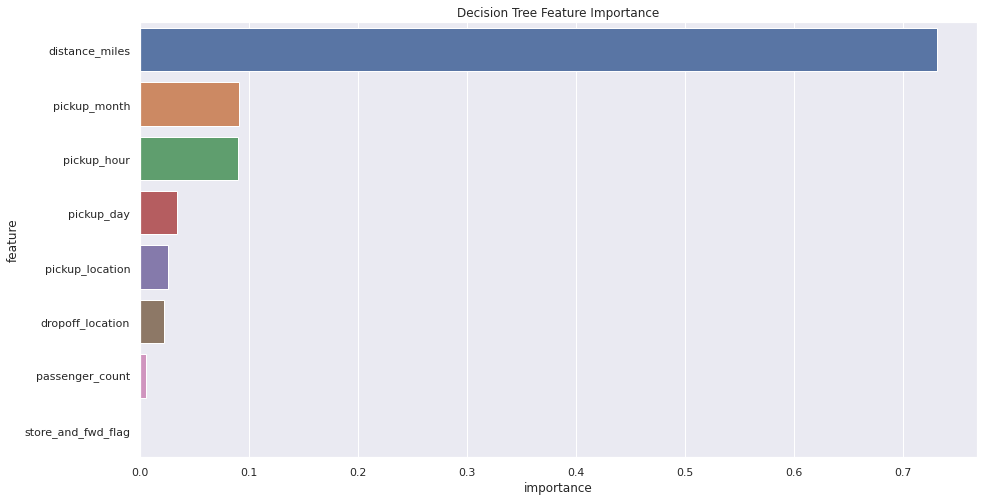

In [70]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

# Model 2 RandomForestRegressor

The second model that I am going to train is a RandomForestRegressor

In [71]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
rf1 = RandomForestRegressor(n_jobs=-1, random_state=42)

In [73]:
rf1.fit(train_inputs,train_targets)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [74]:
train_targets_pred=rf1.predict(train_inputs)

In [75]:
train_loss = mean_squared_error(train_targets, train_targets_pred)

In [76]:
train_loss

34426.958423749995

In [77]:
rf1.score(train_inputs,train_targets)

0.929336819184423

In [78]:
rf1_val_preds = rf1.predict(val_inputs)

In [79]:
val_targets_pred=tree.predict(val_inputs)

In [80]:
val_loss= mean_squared_error(val_targets, val_targets_pred)

In [81]:
val_loss

181823.6

In [82]:
rf1.score(val_inputs,val_targets)

0.6424299007364969

# Model 3 LinearRegression

The third model that I am going to train is a LinearRegression

In [83]:
model=LinearRegression()

In [84]:
model = LinearRegression().fit(train_inputs, train_targets)

# Generate predictions
predictions = model.predict(train_inputs)

In [85]:
train_loss = mean_squared_error(train_targets, predictions)

In [86]:
train_loss

248083.7221201105

In [87]:
model.score(train_inputs,train_targets)

0.4907948388062916

In [88]:
val_predictions= model.predict(val_inputs)

In [89]:
val_loss = mean_squared_error(train_targets, predictions)

In [90]:
val_loss

248083.7221201105

In [91]:
model.score(val_inputs,val_targets)

0.3348218669604104

# Model 4 XGBRegressor

The fourth model that I am going to train is a XGBRegressor

In [92]:
from xgboost import XGBRegressor

In [93]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [94]:
model.fit(train_inputs, train_targets)

[13:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=4, n_estimators=20, n_jobs=-1, random_state=42)

In [95]:
preds = model.predict(train_inputs)

In [96]:
train_loss = mean_squared_error(train_targets, preds)

In [97]:
train_loss

70570.93574427768

In [98]:
model.score(train_inputs,train_targets)

0.8551493648831273

In [99]:
val_preds = model.predict(val_inputs)

In [100]:
val_loss = mean_squared_error(val_targets, val_preds)

In [101]:
val_loss

202980.0431881786

In [102]:
model.score(val_inputs,val_targets)

0.4589798486210622

## Feature importance

 XGBoost also provides a feature importance score for each column in the input.

In [103]:
importance_df = pd.DataFrame({
    'feature': val_inputs.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [104]:
importance_df.head(10)

,feature,importance
1,distance_miles,0.598005
5,pickup_month,0.107259
2,pickup_hour,0.107026
6,pickup_location,0.077638
7,dropoff_location,0.055364
0,passenger_count,0.044058
4,pickup_day,0.010650
3,store_and_fwd_flag,0.000000


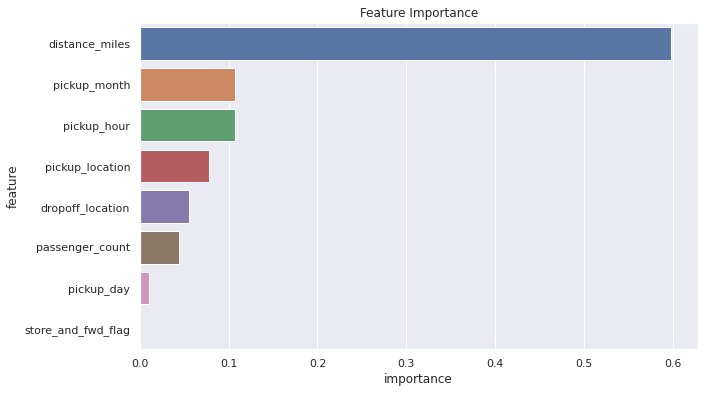

In [105]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');


## K Fold Cross Validation
We'll use a different validation strategy this time, called K-fold cross validation

In [106]:
from sklearn.model_selection import KFold

In [107]:
from sklearn.metrics import mean_squared_error


In [108]:
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)


In [109]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse


In [110]:
kfold = KFold(n_splits=5)

In [111]:
models = []

for train_idxs, val_idxs in kfold.split(inputs_df):
    train_inputs, train_targets = inputs_df.iloc[train_idxs], targets.iloc[train_idxs]
    val_inputs, val_targets = inputs_df.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(train_inputs, 
                                                     train_targets, 
                                                     val_inputs, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))


[13:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 282.9215051224088, Validation RMSE: 501.4156581336584
[13:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 278.22975382381924, Validation RMSE: 458.46521675074945
[13:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 231.19437246750803, Validation RMSE: 790.7074920143757
[13:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 270.69066862959744, Validation RMSE: 449.3663101969354
[13:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 283.9057607652019, Validation RMSE: 447.46522033337374


In [112]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)


In [113]:
preds = predict_avg(models, inputs_df)

In [114]:
preds

array([ 487.68994,  496.79517, 1609.2585 ,  426.6065 ,  349.3278 ,
        383.84268,  296.38428, 1190.5608 ,  317.67694, 1034.845  ,
        985.0438 ,  898.847  ,  733.6171 ,  240.02946, 1193.6575 ,
        202.29036, 1598.4222 ,  604.6256 , 1221.9454 ,  313.09448,
        490.92188,  601.9355 ,  427.7914 , 1182.4935 , 1714.7451 ,
       1207.0936 , 1018.16766,  692.3186 ,  774.5682 , 1934.6641 ,
       1276.5127 , 1170.0583 ,  936.3299 , 1869.3105 ,  506.79095,
        424.90887,  470.26328,  232.0968 ,  948.18787,  913.62177,
       1160.4991 ,  866.4492 ,  841.0752 ,  295.7038 ,  493.36914,
       1434.8666 ,  303.71686,  401.85263, 1024.1326 ,  826.0461 ,
       1371.4812 , 1197.4877 ,  593.7135 ,  337.99985, 1162.6428 ,
       1991.7571 ,  872.77716, 1896.8451 ,  625.7919 ,  982.2028 ,
        648.7958 ,  643.31464,  574.6368 ,  775.06946,  241.36174,
        364.79105,  689.91113,  939.53125,  197.94351,  883.51184,
        848.41223,  452.05707,  106.64122,  489.59674, 1848.44

In [115]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        train_inputs, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        val_inputs, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(train_inputs, train_targets, val_inputs, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

# Hyper-Parameter Tuning
In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm.

A hyperparameter is a parameter whose value is used to control the learning process.

In [116]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(train_inputs, train_targets)
    train_rmse = rmse(model.predict(train_inputs), train_targets)
    val_rmse = rmse(model.predict(val_inputs), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))


## n_estimators
The number of trees to be created. More trees = greater capacity of the model.

In [117]:
test_params(n_estimators=10)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 555.076982957697, Validation RMSE: 667.3867650110902


In [118]:
test_params(n_estimators=10)


[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 555.076982957697, Validation RMSE: 667.3867650110902


In [119]:
test_params(n_estimators=100)


[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 82.86420482105146, Validation RMSE: 291.1980033418279


In [120]:
test_params(n_estimators=400)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 4.355110353837723, Validation RMSE: 280.1441550930396


## max_depth
 As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [121]:
test_params(max_depth=2)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 222.97147756445986, Validation RMSE: 254.79416917024287


In [122]:
test_params(max_depth=6)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 3.7408298727217693, Validation RMSE: 391.127638453683


In [123]:
test_params(max_depth=4)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 24.71443566110006, Validation RMSE: 281.64159352630554


## learning_rate
The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.


In [124]:
test_params(n_estimators=400, learning_rate=0.01)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 212.2565168087213, Validation RMSE: 336.9555346497022


In [125]:
test_params(n_estimators=400, learning_rate=0.1)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 4.355110353837723, Validation RMSE: 280.1441550930396


In [126]:
test_params(n_estimators=400, learning_rate=0.3)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 0.0018741037840345962, Validation RMSE: 252.9114086943572


In [127]:
test_params(n_estimators=400, learning_rate=0.15)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 0.47060580365575916, Validation RMSE: 236.4991747520863


In [128]:
test_params(subsample=0.9)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 70.92869247343457, Validation RMSE: 274.446345198172


In [129]:
test_params(subsample=0.7)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 75.48992939665729, Validation RMSE: 266.43904313598347


In [130]:
test_params(subsample=1)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 82.86420482105146, Validation RMSE: 291.1980033418279


In [131]:
test_params(colsample_bytree=0.7)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 113.41234352756027, Validation RMSE: 317.3723478111917


In [132]:
test_params(colsample_bytree=0.5)

[13:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 107.40429638834046, Validation RMSE: 362.66460585941564


In [133]:
test_params(colsample_bytree=0.9)

[13:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 90.32690164722128, Validation RMSE: 274.15343085778


# Putting it Together and Making Predictions
Let's train a final model on the entire training set with custom hyperparameters.


In [134]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=100, 
                     learning_rate=0.3, max_depth=2, subsample=0.7, 
                     colsample_bytree=0.9)


In [135]:
model.fit(inputs_df, targets)

[13:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.9, learning_rate=0.3, max_depth=2, n_jobs=-1,
             random_state=42, subsample=0.7)

# Preparing Test_df

In [136]:
test_df

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N
5,id0668992,1,2016-06-30 23:59:30,1,-73.991302,40.749798,-73.980515,40.786549,N
6,id1765014,1,2016-06-30 23:59:15,1,-73.978310,40.741550,-73.952072,40.717003,N
7,id0898117,1,2016-06-30 23:59:09,2,-74.012711,40.701527,-73.986481,40.719509,N
8,id3905224,2,2016-06-30 23:58:55,2,-73.992332,40.730511,-73.875618,40.875214,N
9,id1543102,2,2016-06-30 23:58:46,1,-73.993179,40.748760,-73.979309,40.761311,N


In [137]:
test_df["pickup_datetime"]= pd.to_datetime(test_df["pickup_datetime"])
test_df['pickup_day']= test_df["pickup_datetime"].dt.day_name()
test_df['pickup_month']= test_df["pickup_datetime"].dt.month_name()
test_df['pickup_day_no']=test_df['pickup_datetime'].dt.weekday
test_df['pickup_hour']=test_df['pickup_datetime'].dt.hour


In [138]:
test_df['pickup_timeofday']=test_df['pickup_hour'].apply(time_of_day)

In [139]:
test_df["distance_miles"] = distance(test_df["pickup_latitude"], test_df["pickup_longitude"], 
                                      test_df["dropoff_latitude"], test_df["dropoff_longitude"])



In [140]:
test_df["pickup_location"] = np.vectorize(city_state_country)(test_df["pickup_latitude"], test_df["pickup_longitude"])
test_df["dropoff_location"] = np.vectorize(city_state_country)(test_df["dropoff_latitude"], test_df["dropoff_longitude"])

In [141]:
catogorical_df=test_df[['id','store_and_fwd_flag','pickup_day','pickup_month','pickup_location','dropoff_location']].copy()
numerical_df=test_df[['id','passenger_count','distance_miles','pickup_hour']].copy()


In [142]:
from sklearn.preprocessing import  LabelEncoder
encoder = LabelEncoder()
catogorical_df['store_and_fwd_flag']=encoder.fit_transform(test_df['store_and_fwd_flag'])
catogorical_df['pickup_day']=encoder.fit_transform(test_df['pickup_day'])
catogorical_df['pickup_month']=encoder.fit_transform(test_df['pickup_month'])
catogorical_df['pickup_location']=encoder.fit_transform(test_df['pickup_location'])
catogorical_df['dropoff_location']=encoder.fit_transform(test_df['dropoff_location'])

In [143]:
test_input_df=numerical_df.merge(catogorical_df,left_on='id', right_on='id')
test_input_df=test_input_df.drop(['id'],axis='columns')

# Making predictions on the test data

In [144]:
test_preds = model.predict(test_input_df)

In [145]:
submission_df=test_df[['id']].copy()

In [146]:
submission_df['trip_duration']=test_preds

In [147]:
submission_df

,id,trip_duration
0,id3004672,812.557007
1,id3505355,1256.600952
2,id1217141,404.700470
3,id2150126,1601.774536
4,id1598245,448.065613
5,id0668992,1154.280151
6,id1765014,1172.125122
7,id0898117,1433.855469
8,id3905224,2100.426270
9,id1543102,847.526062


In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="taxi-trip-duration-prediction")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 